# Identifying Negative Sentiment in Tweets with Natural Language Processing

## Overview

Google is aiming to increase Android's share of the U.S. smartphone and tablet markets. To do so, they are seeking information on what consumers don't like about their devices. Google hopes to use social media posts to identify complaints and pain points. Once Google has an understanding of common user frustrations, it can engineer improvements that will attract and retain more customers.

## Business Problem

While negative sentiment toward products is available in form of survey responses and customer complaints, Google also hopes to access the opinions conveyed in social media posts.  Google is frustrated that their analysts spend so much time reading social media to find the complaining posts, which comprise just 6% of all posts. My task is to build a natural language processing model which can identify negative-sentiment posts. They would like analysts to be able to work at least twice as fast while still catching as many negative posts as possible. So, negative posts should comprise at least 12% of the list returned by the model.

## Data Understanding

To identify posts with gripes, I analyzed over 9,000 tweets from a dataset provided by Crowdflower via [data.world](https://data.world/crowdflower/brands-and-product-emotions).  The tweets all contain references to Google or Apple products by participants in the South by Southwest (SXSW) Conference in 2011.  Although the data are a decade old, and the products discussed seem ancient (e.g. iPad 2), the words used to convey negative emotions have not changed.  

Each tweet in the dataset has been labeled by a human rater as showing a positive emotion, negative emotion, or no emotion toward the Google or Apple product mentioned.  A few were also labeled "I can't tell."  59% of tweets were tagged as postive, 33% as neutral, and 6% as negative, making negative tweets the smallest category aside from "I can't tell."

After tokenization, the tweets contained just 9,780 unique words, and many of these were numbers, symbols, typos, and words combined into hashtag phrases.

## Data Preparation

The data contained just one null value in the tweet text, which I dropped.

To prepare the data for modeling, I combined the positive, neutral, and I-can't-tell categories in order to build a binary classification model that can identify negative tweets.

I also set aside 10% of the data as a holdout set, which I later used to validate the final model.

In [1]:
# import code libraries

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', 1000)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.naive_bayes import ComplementNB, MultinomialNB

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

import utils as ut

In [2]:
# import data

data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')


In [3]:
# read thru some data

data.head(200)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion


In [4]:
# check data length

len(data)

9093

In [5]:
# change column names to 'text' and 'label'

data.rename(columns={'tweet_text':'text', 'is_there_an_emotion_directed_at_a_brand_or_product': 'label'}, inplace=True)

In [6]:
# drop product column since this model will only predict sentiment, not the product as well

data.drop(columns = 'emotion_in_tweet_is_directed_at', inplace=True)

In [7]:
# data has one null value in the text

data.isna().sum()

text     1
label    0
dtype: int64

In [8]:
# drop null value

data.dropna(inplace=True)

In [9]:
# recheck data length

len(data)

9092

In [10]:
# reset index after dropping null value so train/test splits work later on

data.reset_index(drop=True, inplace=True)

In [11]:
# check label distribution

data['label'].value_counts(normalize=True)

No emotion toward brand or product   0.59261
Positive emotion                     0.32754
Negative emotion                     0.06269
I can't tell                         0.01716
Name: label, dtype: float64

In [12]:
# create temporary df to plot original label distribution

df_plot = pd.DataFrame(data['label'].value_counts(normalize=True)).reset_index()
df_plot.rename(columns={'label': 'Per Cent of Tweets', 'index': 'Sentiment'}, inplace=True)
df_plot['Sentiment'] = df_plot['Sentiment'].map(lambda x: 'No emotion' if x == 'No emotion toward brand or product'
                                               else x)
df_plot['Per Cent of Tweets'] = df_plot['Per Cent of Tweets'].map(lambda x: round(x*100, 2))

In [13]:
df_plot

,Sentiment,Per Cent of Tweets
0,No emotion,59.26000
1,Positive emotion,32.75000
2,Negative emotion,6.27000
3,I can't tell,1.72000


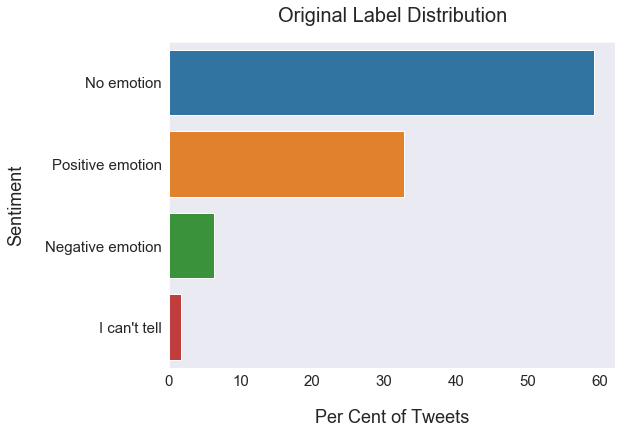

In [14]:
# plot original label distribution

fig = plt.figure(figsize=(8,6))
sns.set_style('dark')
sns.barplot(x='Per Cent of Tweets', y='Sentiment', data=df_plot, orient='h')
plt.title('Original Label Distribution', fontsize=20, pad=20)
plt.xlabel('Per Cent of Tweets', fontsize=18, labelpad=20)
plt.ylabel('Sentiment', fontsize=18, labelpad=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);
plt.savefig('images/orig-label-distribution', bbox_inches='tight')



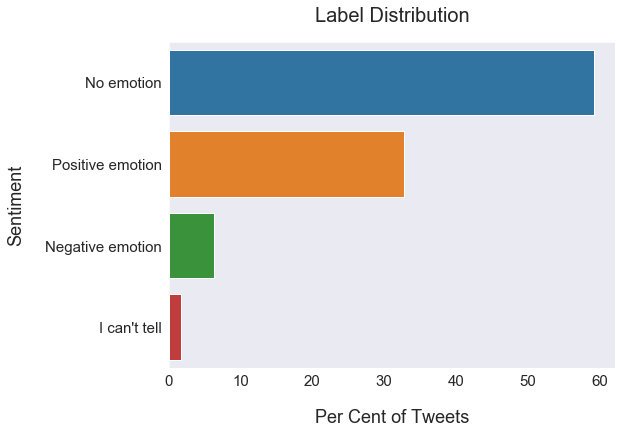

In [15]:
# plot original label distribution with shorter title for README

fig = plt.figure(figsize=(8,6))
sns.set_style('dark')
sns.barplot(x='Per Cent of Tweets', y='Sentiment', data=df_plot, orient='h')
plt.title('Label Distribution', fontsize=20, pad=20)
plt.xlabel('Per Cent of Tweets', fontsize=18, labelpad=20)
plt.ylabel('Sentiment', fontsize=18, labelpad=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);
plt.savefig('images/label-distribution-readme', bbox_inches='tight')


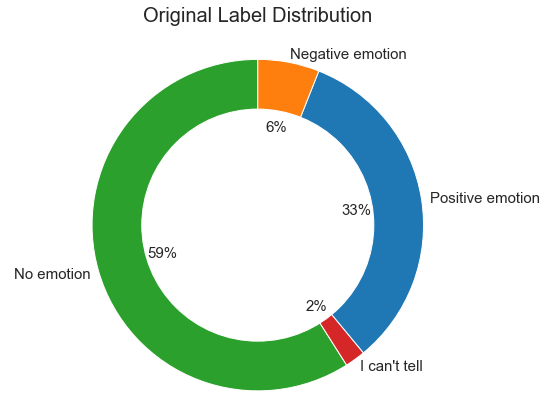

In [16]:
# plot orig label dist in pie chart
# credit to Kevin Anipara for code
# (https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f)

sort_order = ['No emotion', "I can't tell", 'Positive emotion', 'Negative emotion']
sizes = [59, 2, 33, 6]

# explode = (0, 0, 0.2, 0) 

plt.rcParams['font.size'] = 15

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(sizes, 
        labels=sort_order,
        colors=['tab:green', 'tab:red', 'tab:blue', 'tab:orange'],
        autopct='%1.f%%',
        labeldistance=1.05,
        startangle=90)
ax1.set_title('Original Label Distribution', pad=25, fontsize=20)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig('images/label-distribution-pie', bbox_inches='tight')

In [17]:
# combine "No emotion toward brand or product", "I can't tell", and "Positive emotion"
# since the goal is to find negative tweets

data['label'] = data['label'].map(lambda x: 'Not negative' if x != "Negative emotion"
                                 else x)

In [18]:
# check out new label distribution

data['label'].value_counts(normalize=True)

Not negative       0.93731
Negative emotion   0.06269
Name: label, dtype: float64

In [19]:
# create temporary df to plot new label distribution

df_plot_2 = pd.DataFrame(data['label'].value_counts(normalize=True)).reset_index()
df_plot_2.rename(columns={'label': 'Per Cent of Tweets', 'index': 'Sentiment'}, inplace=True)
df_plot_2['Sentiment'] = df_plot_2['Sentiment'].map(lambda x: 'No emotion' if x == 'No emotion toward brand or product'
                                               else x)
df_plot_2['Per Cent of Tweets'] = df_plot_2['Per Cent of Tweets'].map(lambda x: round(x*100, 2))

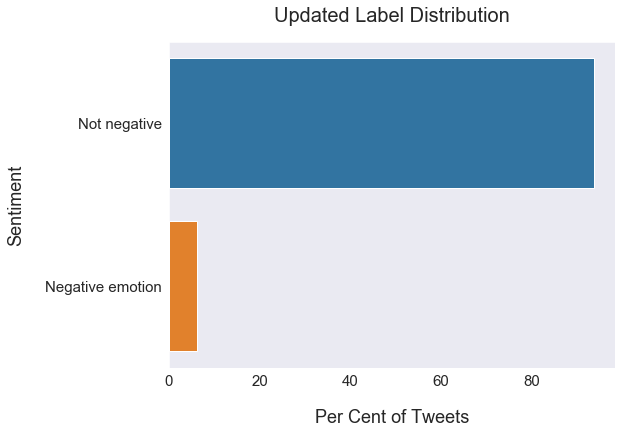

In [20]:
# plot new label distribution

fig = plt.figure(figsize=(8,6))
sns.set_style('dark')
sns.barplot(x='Per Cent of Tweets', y='Sentiment', data=df_plot_2, orient='h')
plt.title('Updated Label Distribution', fontsize=20, pad=20)
plt.xlabel('Per Cent of Tweets', fontsize=18, labelpad=20)
plt.ylabel('Sentiment', fontsize=18, labelpad=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);
plt.savefig('images/upd-label-distribution', bbox_inches='tight')

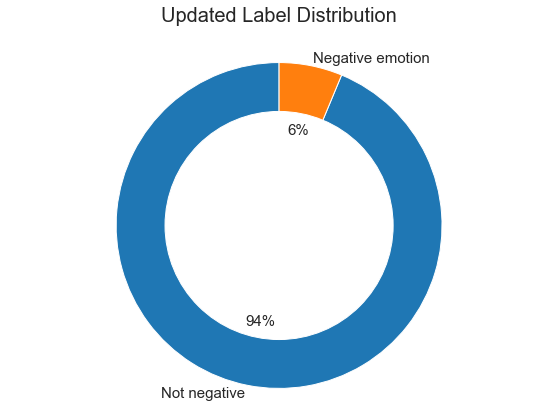

In [21]:
# plot updated label dist in pie chart
# credit to Kevin Anipara for code
# (https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f)

labels = df_plot_2['Sentiment']
sizes = df_plot_2['Per Cent of Tweets']
# explode = (0, 0, 0.2, 0) 

plt.rcParams['font.size'] = 15

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(sizes, 
        labels=labels,
        colors=['tab:blue', 'tab:orange'],
        autopct='%1.f%%',
        labeldistance=1.05,
        startangle=90)
ax1.set_title('Updated Label Distribution', pad=25, fontsize=20)

# draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig('images/label-distribution-pie-upd', bbox_inches='tight')

In [22]:
# create X and y

X = data['text']
y = data['label']


In [23]:
# reformat X to lowercase and string (some tweets were numeric)

X = X.astype(str).map(lambda x: x.lower())


In [24]:
# create holdout set as 10% of data.  Set aside until final model validation

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1, random_state=9117)

print(len(X_train), len(X_holdout))


8182 910


In [25]:
# view X_train

X_train.tail(200)

640                                 i knew if i plied @mention with beer and stogies last night i'd weasel my way into the team android party tonight. #success #sxsw.
135                                                                                                         beautiful #sxsw (@mention apple store, sxsw) [pic]: {link}
888                                                                     hootsuite mobile for #sxsw ~ updates for iphone, blackberry &amp; android {link} (via @mention
7784                                           @mention rt: new #ubersocial for #iphone now in the app store includes uberguide to #sxsw sponsored by #mashable {link}
851                                            for those looking for hig-like guidelines when designing for android {link} by adam beckley #uxamandroid @mention #sxsw
195                                                                       new post: 3 iphone apps we'll be using at south by southwest interactive {link} #sxsw #sxsw

In [26]:
# use a count vectorizer to get length and word counts for total vocabulary

cv = CountVectorizer()
cv_fit = cv.fit_transform(X)
word_list = cv.get_feature_names();    
count_list = cv_fit.toarray().sum(axis=0)
word_df = pd.DataFrame()
word_df['words'] = word_list
word_df['counts'] = count_list

In [27]:
# total vocabulary: 9780 tokens

len(word_df)

9780

In [28]:
# look at most common words, to find words for stop words list

word_df.sort_values(by='counts', ascending=False).head(200)

,words,counts
8334,sxsw,9628
5445,mention,7124
8574,the,4435
5067,link,4313
8714,to,3605
782,at,3105
7306,rt,2967
3751,google,2667
3409,for,2548
4570,ipad,2518


## Modeling

### Model Evaluation

To evaluate all models, I split the data (not including the holdout set) into train and test sets, and found the recall and precision scores for the test set.  The recall score shows what per cent of the true negative-sentiment tweets were captured by each model.  The precision score shows what per cent of the tweets returned by the model are actually negative-sentiment.  In order for Google to reduce their analysts' workload by half, precision must be at least 12%, since 6% of all tweets are negative-sentiment.  Recall should be as high as possible.

I cross-validated the scores by testing each model using five different train/test splits.  I then used the means of all five test set recall and precision scores as the final scores for that model.

### Model 1: Baseline Model

The first model I tested used ScikitLearn's CountVectorizer to turn each tweet into a numerical vector by counting how many times each word appeared in the tweet.  For this initial model, I included only single words and not n-grams in the vectorizer, and I did not set a maximum limit on the number of features.
I then fed the vectorized tweets into ScikitLearn's Multinomial Naive Bayes classifier.  This classifier supports binary as well as multi-class problems with discrete features, such as text classification.

The baseline model's **recall score was 0.12**, and its **precision score was 0.51**, as shown below.  While this model would significantly speed up analysts' work as half of all tweets returned are truly negative-sentiment, it would not be useful to Google because about 90% of negative-sentiment tweets would be missed.  The model is also overfit, suggesting it is relying too heavily on features of the training set.

In [29]:
# create count vectorizer for testing

countvec = CountVectorizer()

In [30]:
# create Multinomial Naive Bayes model for testing

multnb = MultinomialNB()

Vectorizer: CountVectorizer()
Classifier: MultinomialNB()
Cross-validation folds: 5


Train mean recall: 0.39 +/- 0.01
Train mean precision: 0.73 +/- 0.01
Train mean F1: 0.51 +/- 0.01


Test mean recall: 0.12 +/- 0.05
Test mean precision: 0.51 +/- 0.14
Test mean F1: 0.2 +/- 0.08


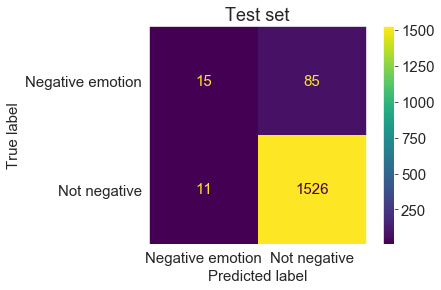

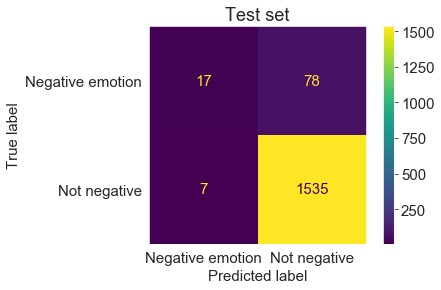

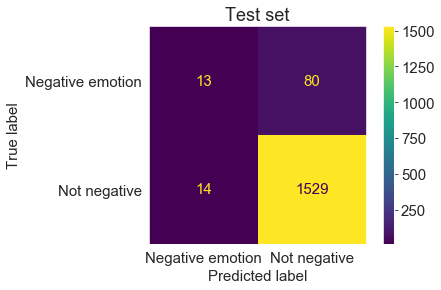

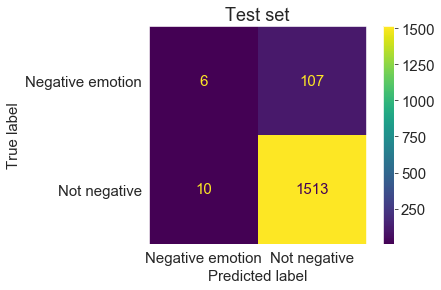

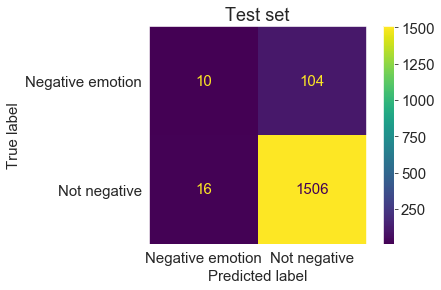

In [31]:
# test baseline model with basic countvectorizer and Multinomial Bayes model

ut.k_fold_validator(X_train, y_train, vectorizer=countvec, classifier=multnb, cv=5)


### Model 2: TF-IDF Model

Next, I tested using a Term Frequency/Inverse Document Frequency vectorizer instead of the count vectorizer.  This model produced even worse results, with a **mean recall score of 0**, meaning the model did not predict any tweets were negative-sentiment.  A TF-IDF vectorizer downscales words that appear often in many documents to highlight words that truly typify one document.  Tweets are so short that few words appear multiple times in any one tweet, and this is possibly why the model could not learn anything from the training data.

In [32]:
# create TF-IDF vectoriser for testing

tfidfvec = TfidfVectorizer()

Vectorizer: TfidfVectorizer()
Classifier: MultinomialNB()
Cross-validation folds: 5


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics



Train mean recall: 0.0 +/- 0.0
Train mean precision: 0.8 +/- 0.45
Train mean F1: 0.01 +/- 0.01


Test mean recall: 0.0 +/- 0.0
Test mean precision: 0.0 +/- 0.0
Test mean F1: 0.0 +/- 0.0


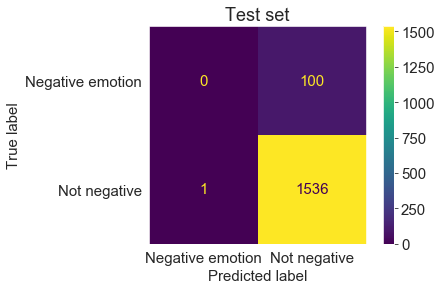

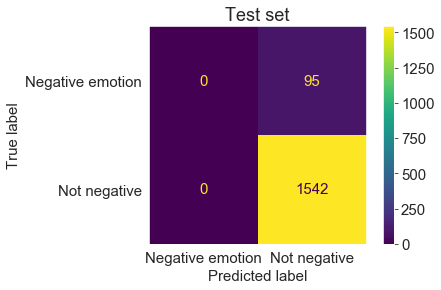

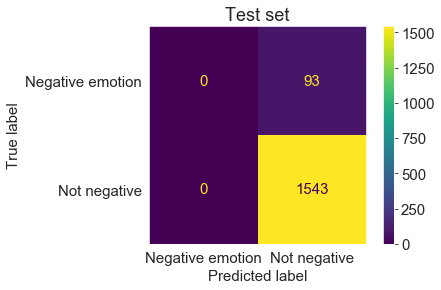

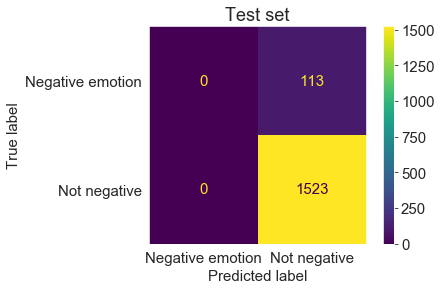

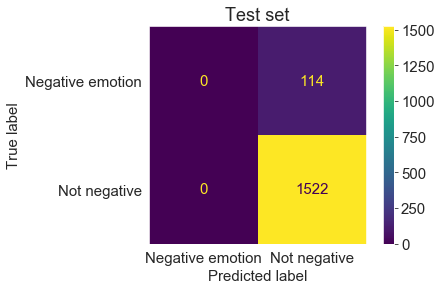

In [33]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=tfidfvec, classifier=multnb, cv=5)

### Model 3: Complement Naive Bayes Model

This model used a count vectorizer with a ScikitLearn's Complement Naive Bayes classifier.  This classifier is designed to remedy class imbalance, which is a significant hurdle in this problem.  

This model **improved recall to 0.2**, at the cost of **precision which fell to 0.33**.  Since 0.34 is still above the 12% threshold set by Google, we will stick with this model to catch more negative-sentiment tweets.

In [34]:
compnb = ComplementNB()

Vectorizer: CountVectorizer()
Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.58 +/- 0.02
Train mean precision: 0.51 +/- 0.01
Train mean F1: 0.54 +/- 0.01


Test mean recall: 0.2 +/- 0.05
Test mean precision: 0.33 +/- 0.06
Test mean F1: 0.25 +/- 0.06


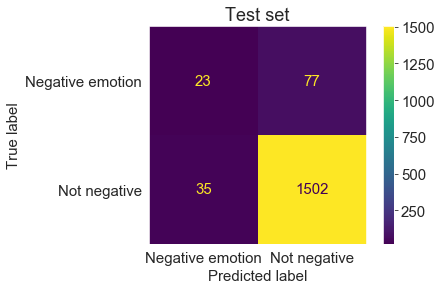

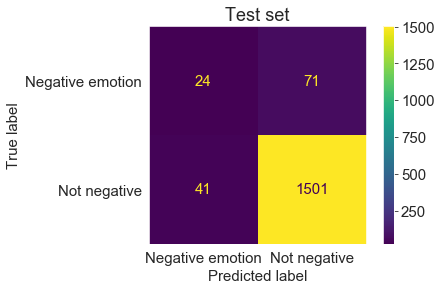

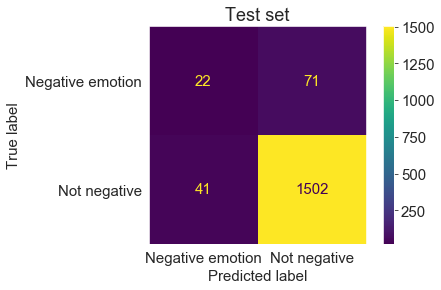

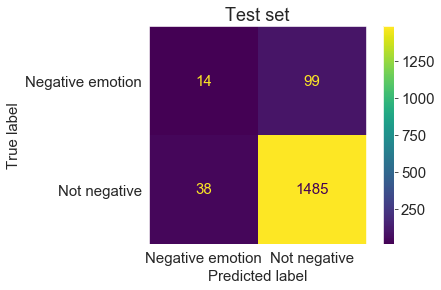

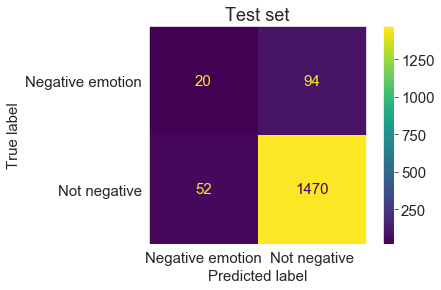

In [35]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=countvec, classifier=compnb, cv=5)

### Model 4: Count Vectorizer with Stop Words

This model used a count vectorizer that contained a list of stop words - words to exclude from the vectorized data's features.  This list included common English stopwords from Natural Language Toolkit, and punctuation.  The model used a Complement Naive Bayes classifier.

Including these stopwords improved **recall to 0.33**, while **precision fell to 0.28**.

In [36]:
# create stopwords list for testing

stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
stopwords_list += ['sxsw','mention','rt']

In [37]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [38]:
# create new count vectorizer that includes stopwords

cv_stop = CountVectorizer(stop_words=stopwords_list)

Vectorizer: CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.72 +/- 0.01
Train mean precision: 0.42 +/- 0.01
Train mean F1: 0.53 +/- 0.01


Test mean recall: 0.33 +/- 0.06
Test mean precision: 0.28 +/- 0.02
Test mean F1: 0.3 +/- 0.03


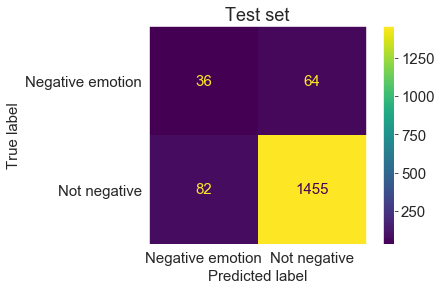

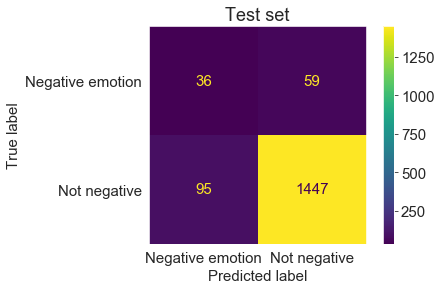

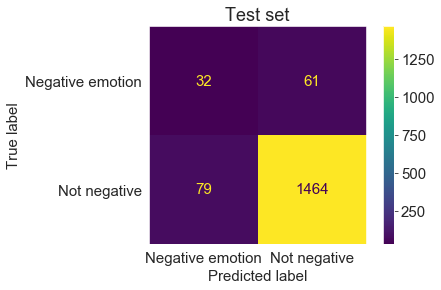

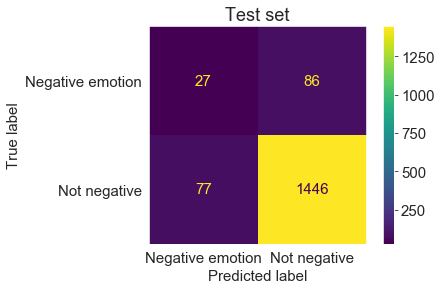

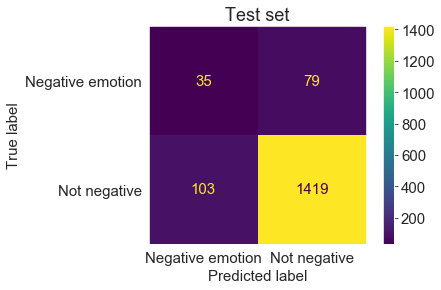

In [39]:
# test model 3

ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop, classifier=compnb, cv=5)

### Model 5: Count Vectorizer with Short Stop Words List

Next, I tested a model with a very short stop words list, thinking that because tweets are brief, we may be getting good information from the small words and punctuation that had been excluded.  

However, this stop words list did not improve model performance, as **recall fell significantly to 0.23.  Precision climbed only slightly to 0.31** but at the cost of missed negative-sentiment tweets.  We will stick with the complete stop words list for now, but later will see that the shorter stop words list works better when using n-grams.

In [40]:
# create alternative stopwords list for testing
# since tweets are so short, we may be getting good info from punctuation and small words

stopwords_list_2 = ['sxsw', 'mention', 'rt']

In [41]:
cv_stop_2 = CountVectorizer(stop_words=stopwords_list_2)

Vectorizer: CountVectorizer(stop_words=['sxsw', 'mention', 'rt'])
Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.61 +/- 0.02
Train mean precision: 0.48 +/- 0.01
Train mean F1: 0.54 +/- 0.01


Test mean recall: 0.23 +/- 0.06
Test mean precision: 0.31 +/- 0.03
Test mean F1: 0.26 +/- 0.05


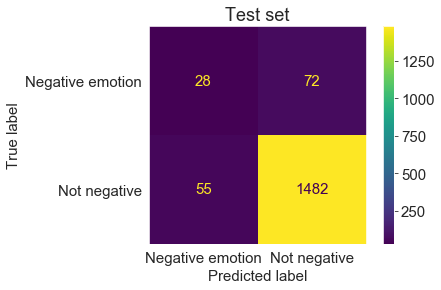

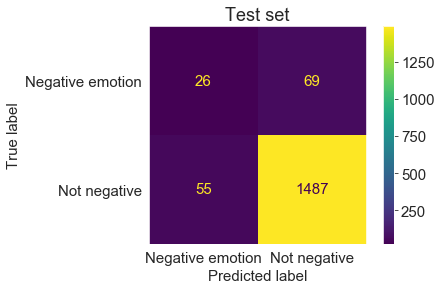

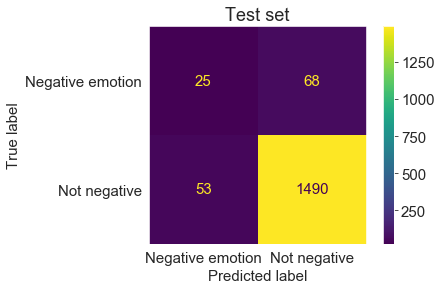

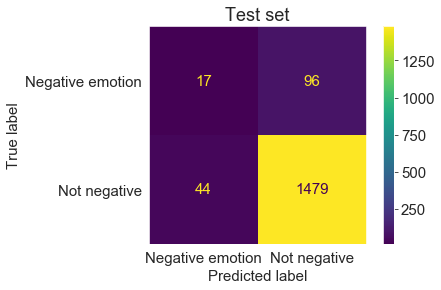

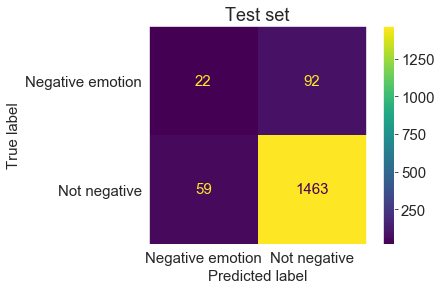

In [42]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_2, classifier=compnb, cv=5)

### Model 6: Count Vectorizer with Stop Words and Max Features

This model set the maximum number of features to include in the vectorized data at 3,000.  

Doing so significantly improved **recall to 0.56** and reduced **precision to 0.19**, still above the threshold of 12%.  Limiting the words to include to only the 3,000 most common words reduced overfitting in the model, and allowed it to classify more tweets as negative-sentiment.

In [43]:
cv_stop_max = CountVectorizer(stop_words=stopwords_list, max_features=3000)

Vectorizer: CountVectorizer(max_features=3000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.82 +/- 0.01
Train mean precision: 0.25 +/- 0.01
Train mean F1: 0.39 +/- 0.01


Test mean recall: 0.56 +/- 0.04
Test mean precision: 0.19 +/- 0.01
Test mean F1: 0.28 +/- 0.01


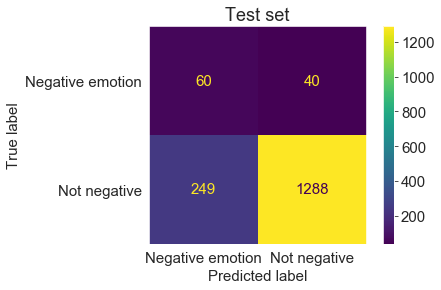

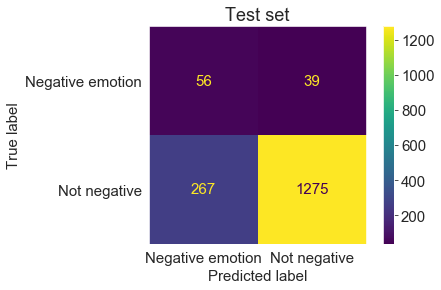

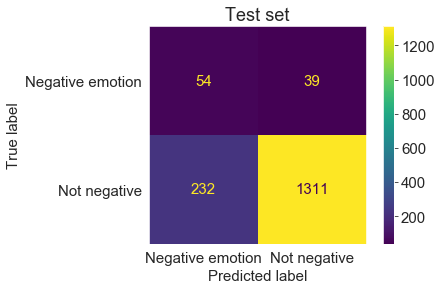

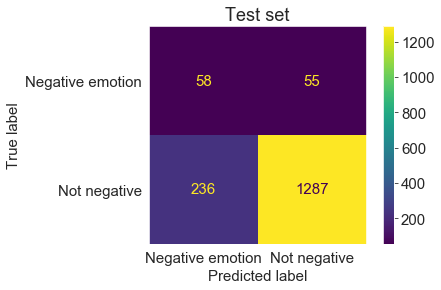

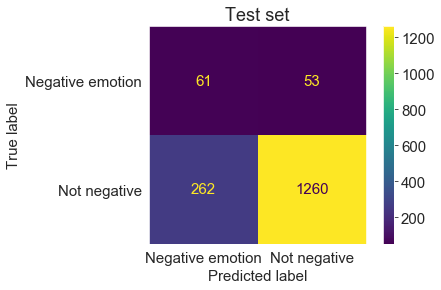

In [44]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_max, classifier=compnb, cv=5)

### Model 7: Count Vectorizer with Stop Words, Max Features, and N-grams

This model set a maximum n-gram length of 3, so single words as well as two- and three-word blocks would all be included as features.  The model retained the stop words list and maximum feature limit used previously.  

**Recall jumped again to 0.65** while **precision fell only slightly to 0.16**, showing that these multi-word blocks are important features that the model can learn from.

In [45]:
cv_stop_max_ngram = CountVectorizer(stop_words=stopwords_list, max_features=3000, ngram_range=(1, 3))

Vectorizer: CountVectorizer(max_features=3000, ngram_range=(1, 3),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.85 +/- 0.01
Train mean precision: 0.2 +/- 0.01
Train mean F1: 0.32 +/- 0.01


Test mean recall: 0.65 +/- 0.04
Test mean precision: 0.16 +/- 0.02
Test mean F1: 0.25 +/- 0.02


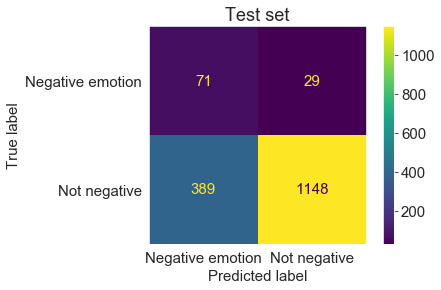

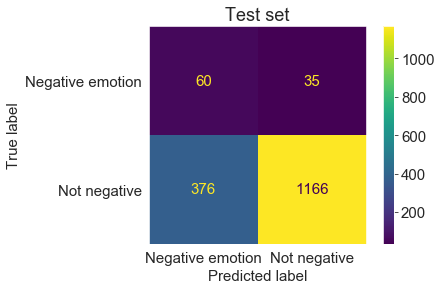

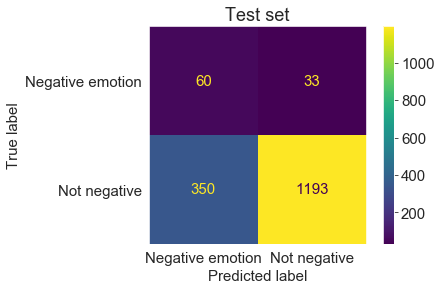

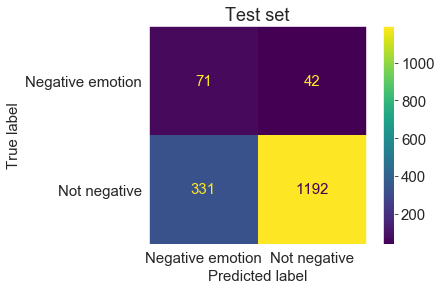

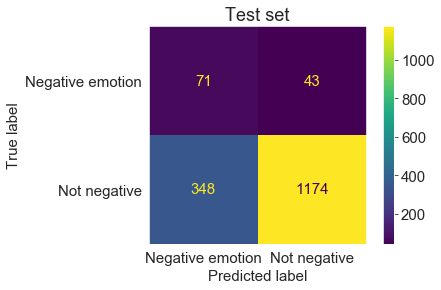

In [46]:
ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_max_ngram, classifier=compnb, cv=5)

### Model 8: Count Vectorizer with Stop Words, N-grams, and no Max Features

This model is identical to Model 7, but does not set a maximum feature limit.  

I was curious to see the affect of n-grams without the feature limit.  This model had a **recall score of only 0.23** and **a precision score of 0.45**.  N-grams only improve recall when a maximum feature limit is set.  As with previous models lacking a maximum feature limit, this model was hugely overfit.

In [47]:
# create count vectorizer with stopwords list and ngrams but no max features limit

cv_stop_ngram = CountVectorizer(stop_words=stopwords_list, ngram_range=(1, 3))

Vectorizer: CountVectorizer(ngram_range=(1, 3),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.9 +/- 0.01
Train mean precision: 0.68 +/- 0.02
Train mean F1: 0.78 +/- 0.01


Test mean recall: 0.23 +/- 0.05
Test mean precision: 0.45 +/- 0.07
Test mean F1: 0.3 +/- 0.05


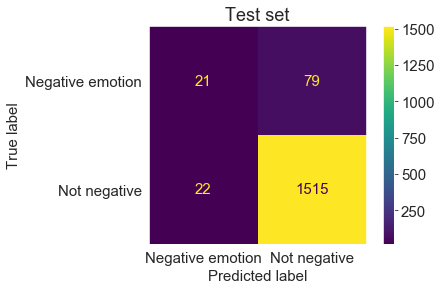

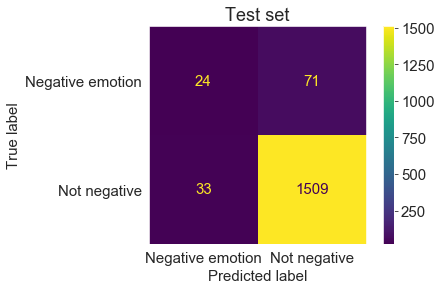

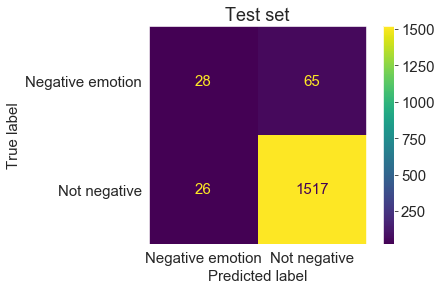

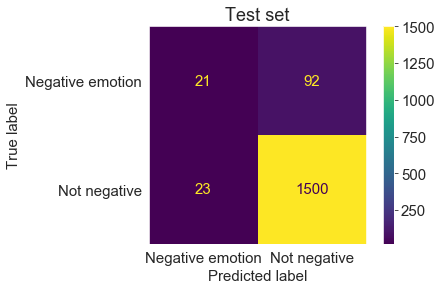

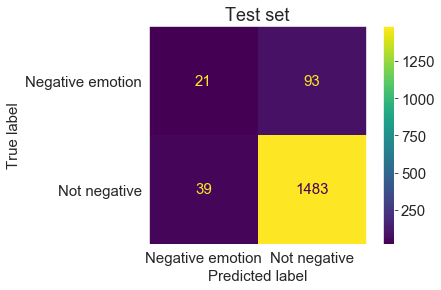

In [48]:
# ngrams don't improve recall without max

ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_ngram, classifier=compnb, cv=5)

### Model 9: Iterate on Maximum Features and N-gram Length

This model attempts to improve on Model 7 by testing maximum feature limits of 2000 and 4000, and n-gram maximum lengths of 2 and 4.  After iterating through these combinations, a maximum feature limit of 2000 and an n-gram range between 1 and 3 performed best.  A maximum feature limit of 1500 performed even better.

**Recall jumped to 0.71 and precision fell slightly to 0.14**, still above the 12% threshold.  This model is much less overfit, indicating that the smaller feature limit stops the model from learning too much from the training set.

In [49]:
# best count vectorizer set maximum features at 1500, ngram range 1-3
# maximum features at 2k was a little better than 3k and 1k, and 1500 worked best
# maximum ngrams at 3 is better than 2 and 4
# minimum ngrams at 1 is better than 2

cv_stop_max_ngram_2 = CountVectorizer(stop_words=stopwords_list, max_features=1500, ngram_range=(1, 3))

Vectorizer: CountVectorizer(max_features=1500, ngram_range=(1, 3),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.86 +/- 0.01
Train mean precision: 0.17 +/- 0.0
Train mean F1: 0.28 +/- 0.01


Test mean recall: 0.71 +/- 0.02
Test mean precision: 0.14 +/- 0.02
Test mean F1: 0.23 +/- 0.02


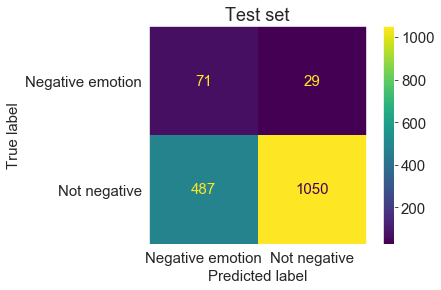

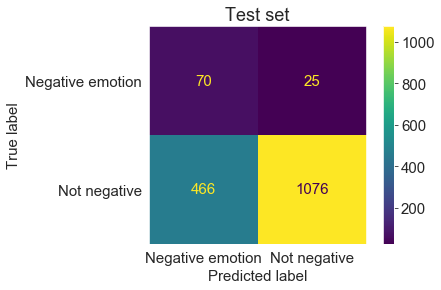

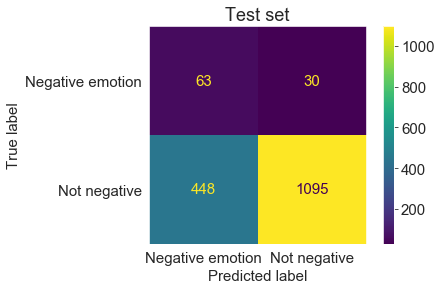

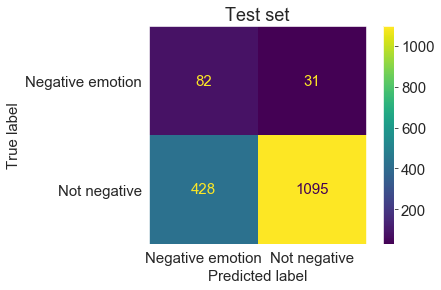

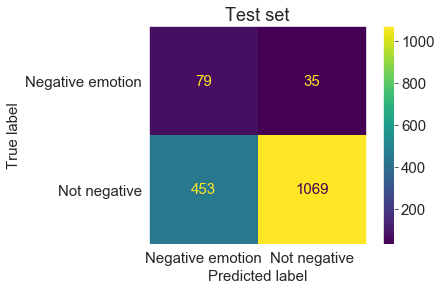

In [50]:
# test model with max features at 1500

ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_max_ngram_2, classifier=compnb, cv=5)

### Model 10: Test Shorter Stop Words List with Current Best Model (# 9)

Since I only iterated on the stop words list before including n-grams, I was curious to see if the small words and punctuation I excluded might be useful now that two- and three-word n-grams are included.  This model uses a list which only contains three very common words in these tweets: 'sxsw', 'rt', and 'mention'.

This change bumped up **recall to 0.77** without sacrificing **precision, which held steady at 0.14**, indicating that when n-grams are included, common small words and punctuation are indeed useful.  This model was the least overfit of any model tested, showing that it is learning only the information necessary to predict sentiment on new data.

In [51]:
cv_stop_max_ngram_3 = CountVectorizer(stop_words=stopwords_list_2, max_features=1500, ngram_range=(1, 3))

Vectorizer: CountVectorizer(max_features=1500, ngram_range=(1, 3),
                stop_words=['sxsw', 'mention', 'rt'])
Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.88 +/- 0.01
Train mean precision: 0.16 +/- 0.0
Train mean F1: 0.27 +/- 0.0


Test mean recall: 0.77 +/- 0.02
Test mean precision: 0.14 +/- 0.02
Test mean F1: 0.24 +/- 0.02


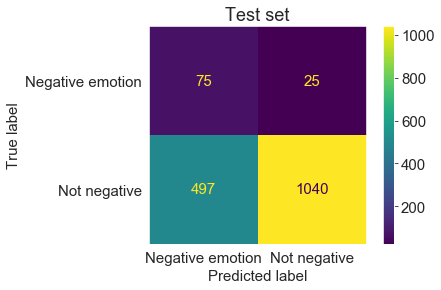

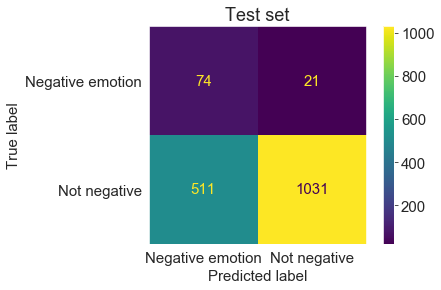

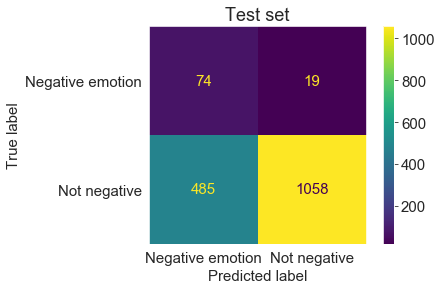

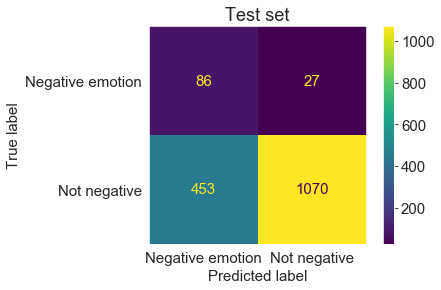

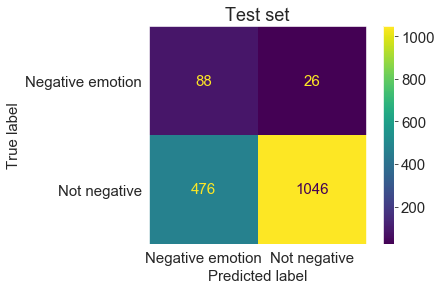

In [52]:

ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_stop_max_ngram_3, classifier=compnb, cv=5)

### Model 11: Test No Stop Words List with Current Best Model (# 9)

This model is the same as Model 10, but includes no stop words list.  **Recall was slightly worse at 0.75**, and **precision held steady at 0.14**, making Model 10 the best and final model.

In [53]:
cv_max_ngram = CountVectorizer(max_features=1500, ngram_range=(1, 3))

Vectorizer: CountVectorizer(max_features=1500, ngram_range=(1, 3))
Classifier: ComplementNB()
Cross-validation folds: 5


Train mean recall: 0.86 +/- 0.01
Train mean precision: 0.16 +/- 0.01
Train mean F1: 0.27 +/- 0.01


Test mean recall: 0.75 +/- 0.03
Test mean precision: 0.14 +/- 0.02
Test mean F1: 0.23 +/- 0.02


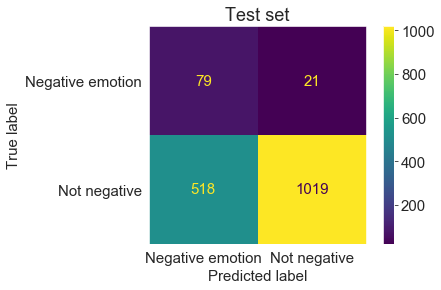

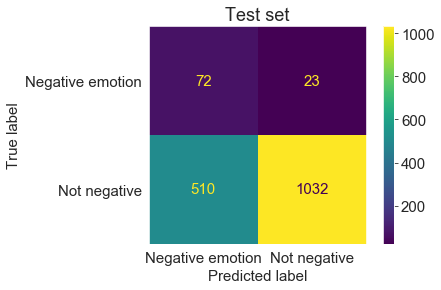

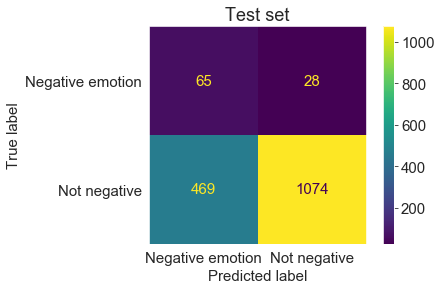

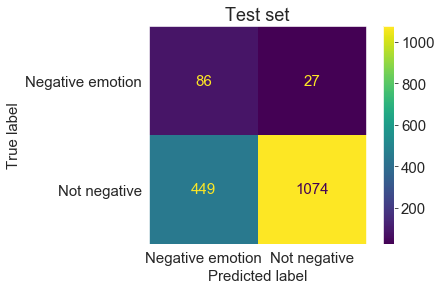

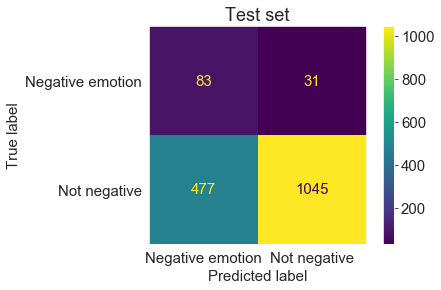

In [54]:

ut.k_fold_validator(predictor=X_train, target=y_train, vectorizer=cv_max_ngram, classifier=compnb, cv=5)

### Final Model

The final natural language processing model includes the following features:

* A count vectorizer with:
    * Maximum feature limit of 1500
    * N-grams of between 1 and 3 words
    * A stop words list with only three words: 'sxsw', 'mention', and 'rt'
    
    
* A Complement Naive Bayesian classifier 

## Holdout Set Evaluation

As a final step, I ran the baseline model and the final model on the holdout set created at the beginning of the notebook to make sure the model could perform well on unseen data.

The model performed even better on the holdout set than it did during the testing process.  **Recall was 0.87**, a full ten percentage points higher, and **precision was also higher at 0.15**.  The model was not overfit, as the recall and precision for the training set were 0.88 and 0.16 respectively.  

The model also performed better than the baseline model, which had recall and precision scores of 0.25 and 0.7 repsectively.  A recall score of 0.25 would mean that too many negative tweets containing valuable information would go undetected.

The improvement in performance on the holdout set vs the test sets used previously may be due to the fact that for this evaluation I trained the model using more data - the entire training set instead of just 75% of it as in the splits performed earlier.  It is also possible that because the holdout set is small (just 10% of the original data), we got lucky and ended up with an easy data set.

Train recall score: 0.42
Train precision score: 0.69
Train F1 score: 0.53


Holdout recall score: 0.25
Holdout precision score: 0.7
Holdout F1 score: 0.37


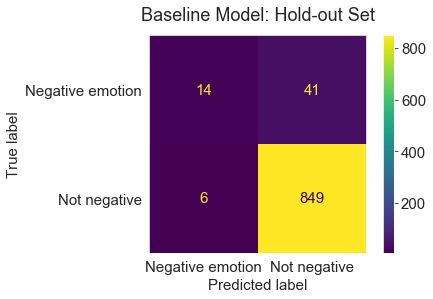

In [55]:
# test baseline model on holdout set

vec = countvec
clf = multnb

X_vec_train = vec.fit_transform(X_train)
X_vec_holdout = vec.transform(X_holdout)

clf.fit(X_vec_train, y_train)

y_pred_train = clf.predict(X_vec_train)
y_pred_holdout = clf.predict(X_vec_holdout)

print('Train recall score:', round(recall_score(y_train, y_pred_train, pos_label='Negative emotion'), 2))
print('Train precision score:', round(precision_score(y_train, y_pred_train, pos_label='Negative emotion'), 2))
print('Train F1 score:', round(f1_score(y_train, y_pred_train, pos_label='Negative emotion'), 2))       
print('\n')
print('Holdout recall score:', round(recall_score(y_holdout, y_pred_holdout, pos_label='Negative emotion'), 2))
print('Holdout precision score:', round(precision_score(y_holdout, y_pred_holdout, pos_label='Negative emotion'), 2))
print('Holdout F1 score:', round(f1_score(y_holdout, y_pred_holdout, pos_label='Negative emotion'), 2))       

plot_confusion_matrix(clf, X_vec_holdout, y_holdout)
plt.title('Baseline Model: Hold-out Set', fontsize=18, pad=15)
plt.savefig('images/baseline-model-holdout')

Train recall score: 0.88
Train precision score: 0.16
Train F1 score: 0.27


Holdout recall score: 0.87
Holdout precision score: 0.15
Holdout F1 score: 0.25


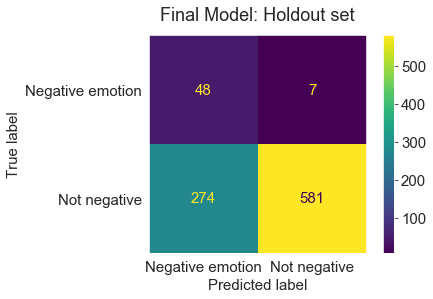

In [56]:
# test final model on holdout set

vec = cv_stop_max_ngram_3
clf = compnb

X_vec_train = vec.fit_transform(X_train)
X_vec_holdout = vec.transform(X_holdout)

clf.fit(X_vec_train, y_train)

y_pred_train = clf.predict(X_vec_train)
y_pred_holdout = clf.predict(X_vec_holdout)

print('Train recall score:', round(recall_score(y_train, y_pred_train, pos_label='Negative emotion'), 2))
print('Train precision score:', round(precision_score(y_train, y_pred_train, pos_label='Negative emotion'), 2))
print('Train F1 score:', round(f1_score(y_train, y_pred_train, pos_label='Negative emotion'), 2))       
print('\n')
print('Holdout recall score:', round(recall_score(y_holdout, y_pred_holdout, pos_label='Negative emotion'), 2))
print('Holdout precision score:', round(precision_score(y_holdout, y_pred_holdout, pos_label='Negative emotion'), 2))
print('Holdout F1 score:', round(f1_score(y_holdout, y_pred_holdout, pos_label='Negative emotion'), 2))       

plot_confusion_matrix(clf, X_vec_holdout, y_holdout)
plt.title('Final Model: Holdout set', fontsize=18, pad=15)
plt.savefig('images/final-model-holdout')



## Conclusions

Identifying negative-sentiment tweets is a challenging problem since they comprise just 6% of all tweets in the dataset.  The final model provides value to Google by enabling analysts to work over twice as fast, while still catching 77% of available negative-sentiment tweets.  

The model's precision score was 0.14, meaning that 14 out of every hundred tweets returned by the model are truly negative-sentiment.  Without the model, analysts would find only 6 negative tweets in every one hundred.  The model's 77% recall rate means that most negative-sentiment tweets would be captured by the model.  Since each tweet contains valuable information that can help Google understand customer frustrations, the company would like to capture as many of these tweets as possible.

The final model improved on the baseline model, which identified only 12% of all negative-sentiment tweets, though about half the tweets it returned truly were negative-sentiment.

## Future Work

Natural language processing is a complex area of machine learning that has many different tools available for data scientists.  Testing additional vectorizers and models may improve on these results.

While a count vectorizer worked well for this problem, the weakness of a count vectorizer is that it does not account for the meanings of words.  Moreover, words that are not in the training set cannot help drive predictions even if they are in the test set.  Pre-trained vectorizers such as Google's Word2Vec, Stanford's GloVe, and SpaCy may produce better results.

There are several other model types which would be interesting to test with this problem.  Decision trees and support vector machines are robust classification algorithms and may work well for this problem.  It would also be interesting to test a neural net.